In [2]:
# 8월 6일 일요일 12시까지
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# from sklearn.tree import export_graphviz
# import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 로지스틱 회귀
from statsmodels.api import Logit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

from scipy.stats import f_oneway

from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline
matplotlib.rc('font',family = 'Noto Sans CJK JP')
matplotlib.rc('axes',unicode_minus = False)

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

# matplotlib.rc('font',family='Malgun Gothic')
matplotlib.rc('font',family='Noto Sans CJK JP')
matplotlib.rc('axes',unicode_minus=False)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [4]:
df_raw=pd.read_csv('/home/piai/빅데이터/빅데이터 프로젝트/B3_반도체/7_Path.csv')
df_raw.head()

,No_Die,Lot_Num,Wafer_Num,Ox_Chamber,photo_soft_Chamber,lithography_Chamber,Etching_Chamber,Chamber_Num,Error_message,Error,Short_Path,Path,Target,Datetime
0,NOLSM325131325,13,28,2,1,1,1,1,none,1,2111,21111,141,01-03-2022
1,NOLSM326132326,13,29,2,1,1,2,2,none,1,2112,21122,55,01-03-2022
2,NOLSM327133327,13,30,2,1,1,3,3,none,1,2113,21133,96,01-03-2022
3,NOLSM328134328,13,31,2,1,1,1,1,none,1,2111,21111,105,01-03-2022
4,NOLSM329135329,13,32,2,1,1,2,2,none,1,2112,21122,79,01-03-2022


In [5]:
df_raw["Datetime"] = pd.to_datetime(df_raw["Datetime"], format="%d-%m-%Y")

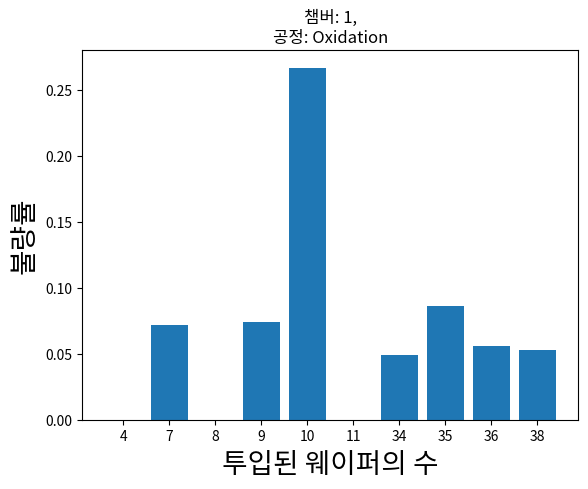

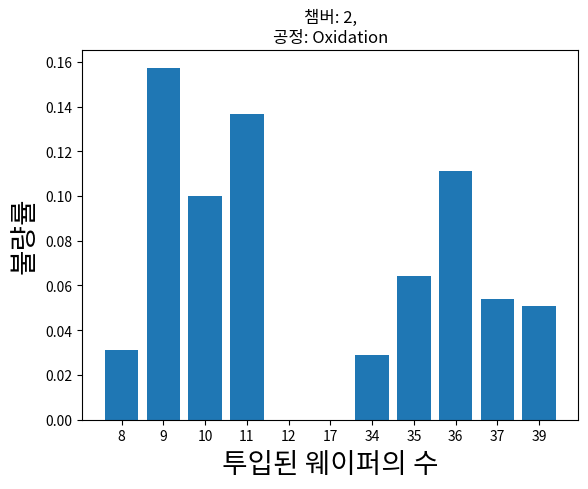

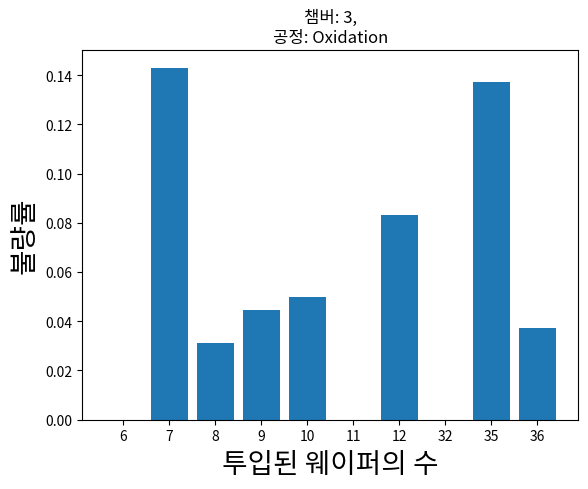

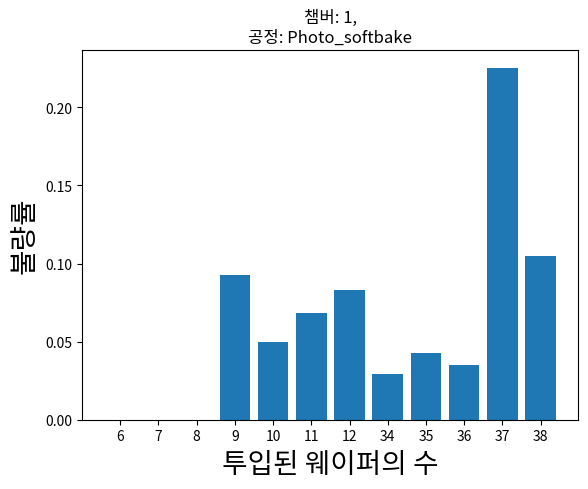

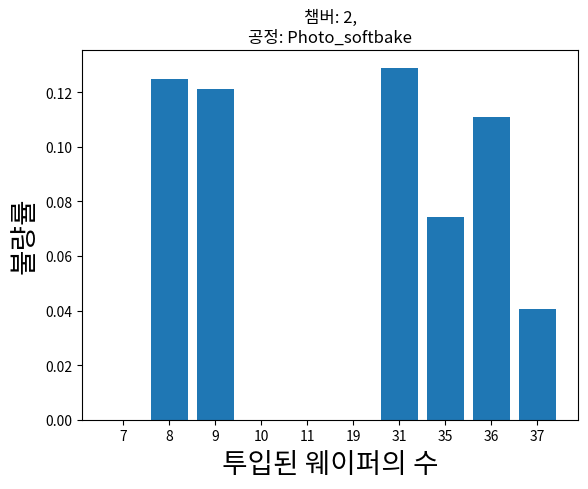

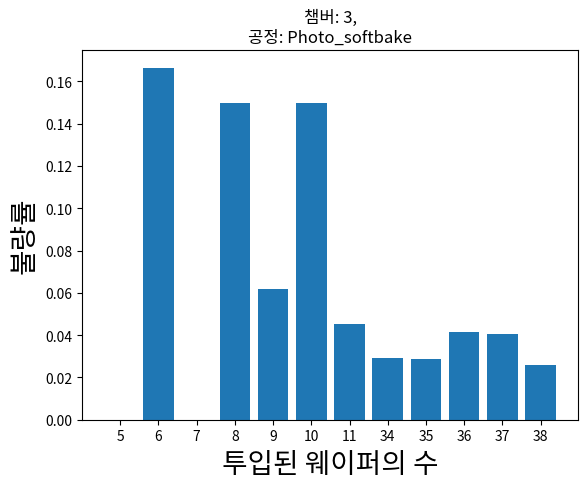

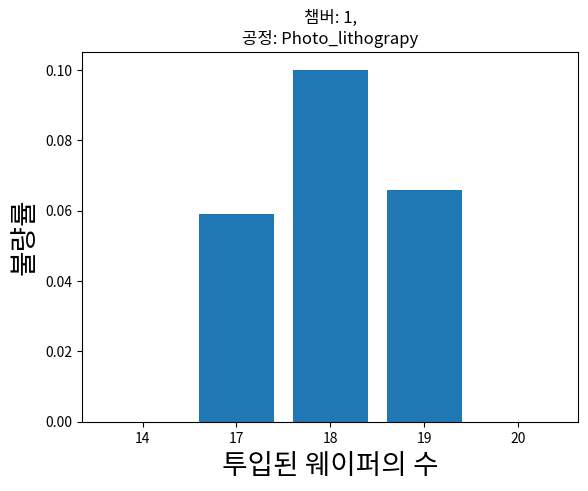

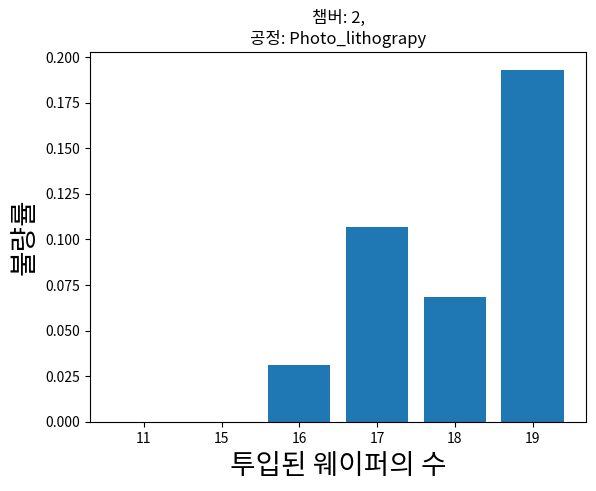

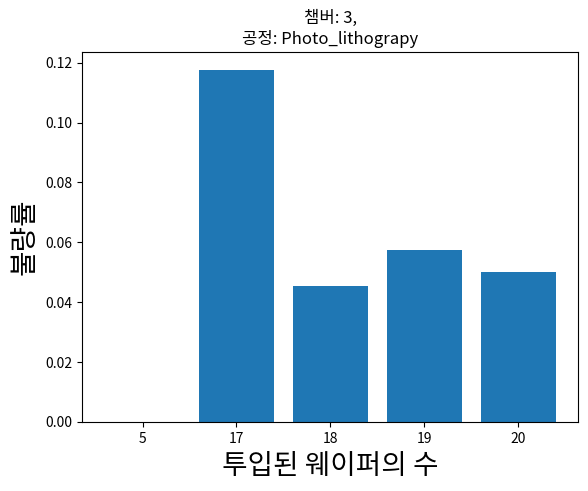

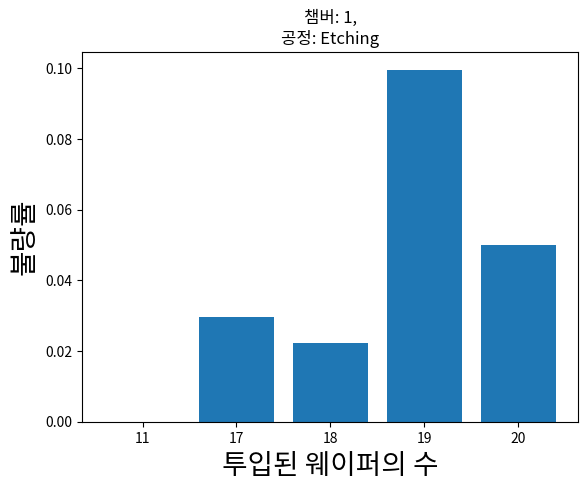

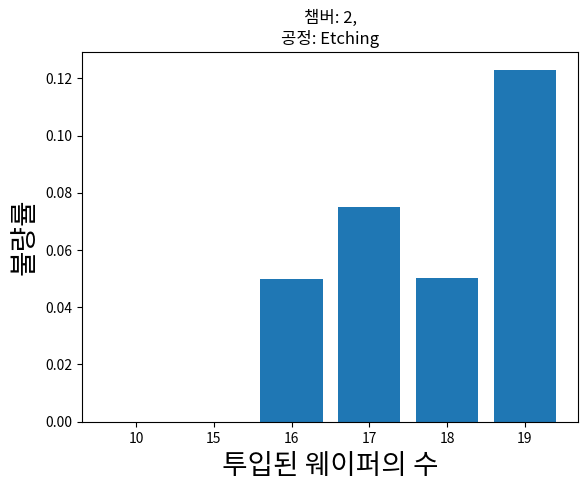

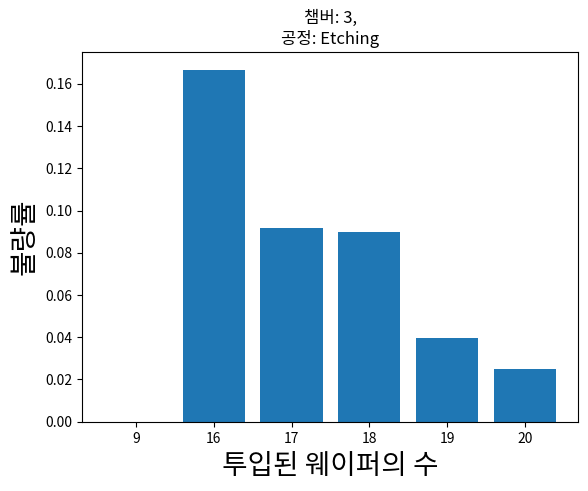

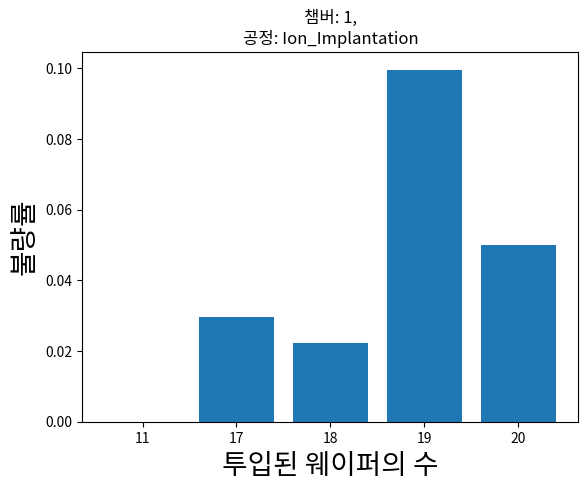

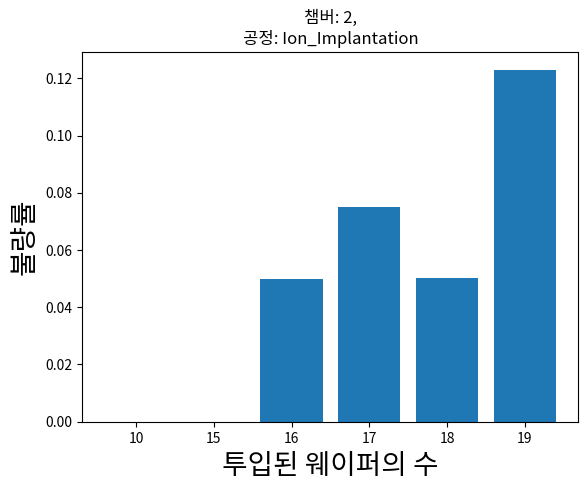

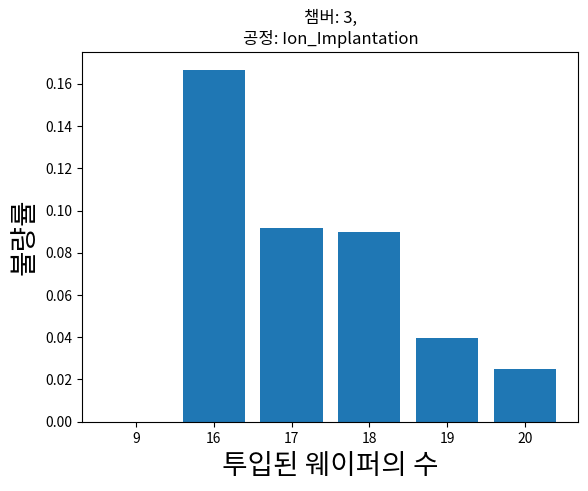

In [32]:
grouped = df_raw.groupby("Lot_Num")

lot_nums = df_raw["Lot_Num"].unique()
chamber_list = ["Ox_Chamber", "photo_soft_Chamber", "lithography_Chamber", "Etching_Chamber", "Chamber_Num"]

for process_chamber in chamber_list:
    for i in range(1,4,1):
        group = df_raw[df_raw[process_chamber] == i]

        # Error가 0인 행의 수 계산
        error_0_counts = group.groupby("Lot_Num").apply(lambda x: x[x["Error"] == 0].shape[0] if not x.empty else 0)
        # print("error_0_counts: ", error_0_counts)

        # 전체 웨이퍼의 수
        lot_all_count = group.groupby("Lot_Num").size()
        # print("lot_all_count: ", lot_all_count)

        # 불량 웨이퍼의 수/전체 행의 수 = 불량률
        fraction_defective=error_0_counts/lot_all_count
        fraction_defective_info_list = {"fraction_defective":[f"{num:.3f}" for num in fraction_defective.values], "lot_all_count":[int(num) for num in lot_all_count.values]}
        # print("fraction_defective_info_list: ", fraction_defective_info_list)

        # count 중복 처리(불량률 평균)
        averaged_data = {
            'lot_all_count': [],
            'fraction_defective_average': [],
        }
        lot_count_to_index = {}
        for j, lot_count in enumerate(fraction_defective_info_list['lot_all_count']):
            if lot_count in lot_count_to_index:
                index = lot_count_to_index[lot_count]
                averaged_data['fraction_defective_average'][index].append(float(fraction_defective_info_list['fraction_defective'][j]))
            else:
                index = len(averaged_data['lot_all_count'])
                lot_count_to_index[lot_count] = index
                averaged_data['lot_all_count'].append(lot_count)
                averaged_data['fraction_defective_average'].append([float(fraction_defective_info_list['fraction_defective'][j])])

        for k in range(len(averaged_data['lot_all_count'])):
            averaged_data['fraction_defective_average'][k] = sum(averaged_data['fraction_defective_average'][k]) / len(averaged_data['fraction_defective_average'][k])

        averaged_df = pd.DataFrame(averaged_data)
        averaged_df.sort_values(by="lot_all_count", inplace=True)
        averaged_df["lot_all_count"]=averaged_df["lot_all_count"].astype("str")

        process_name = ""
        if process_chamber == "Ox_Chamber":
            process_name = "Oxidation"
        elif process_chamber == "photo_soft_Chamber":
            process_name = "Photo_softbake"
        elif process_chamber == "lithography_Chamber":
            process_name = "Photo_lithograpy"
        elif process_chamber == "Etching_Chamber":
            process_name = "Etching"
        elif process_chamber == "Chamber_Num":
            process_name = "Ion_Implantation"
        else:
            process_name = process_chamber  # 기본값으로 처리

        # Bar chart 그리기
        plt.bar(averaged_df['lot_all_count'], averaged_df['fraction_defective_average'])
        plt.xlabel("투입된 웨이퍼의 수", fontsize=20)
        plt.ylabel("불량률", fontsize=20)
        plt.title(f"챔버: {int(i)},\n공정: {str(process_name)}")
        plt.show()

In [13]:
averaged_data = {
    'lot_all_count': [],
    'fraction_defective_average': [],
}

lot_count_to_index = {}

for i, lot_count in enumerate(fraction_defective_info_list['lot_all_count']):
    if lot_count in lot_count_to_index:
        index = lot_count_to_index[lot_count]
        averaged_data['fraction_defective_average'][index].append(float(fraction_defective_info_list['fraction_defective'][i]))
    else:
        index = len(averaged_data['lot_all_count'])
        lot_count_to_index[lot_count] = index
        averaged_data['lot_all_count'].append(lot_count)
        averaged_data['fraction_defective_average'].append([float(fraction_defective_info_list['fraction_defective'][i])])

for i in range(len(averaged_data['lot_all_count'])):
    averaged_data['fraction_defective_average'][i] = sum(averaged_data['fraction_defective_average'][i]) / len(averaged_data['fraction_defective_average'][i])

print(averaged_data)

{'lot_all_count': [17, 19, 16, 18, 20, 9], 'fraction_defective_average': [0.09155555555555556, 0.03975, 0.16666666666666666, 0.08992307692307693, 0.025, 0.0]}


In [18]:
averaged_df = pd.DataFrame(averaged_data)
averaged_df.sort_values(by="lot_all_count", inplace=True)
averaged_df["lot_all_count"]=averaged_df["lot_all_count"].astype("str")
averaged_df

,lot_all_count,fraction_defective_average
5,9,0.000000
2,16,0.166667
0,17,0.091556
3,18,0.089923
1,19,0.039750
4,20,0.025000


Ox_chamber_1<br>
10에서 뜀<br><br>
photo_soft_1<br>
37에서 뜀<br><br>
lithography_2<br>
19에서 뜀<br><br>
etching_1<br>
19에서 뒴<br><br>
etching_2<br>
19에서 뒴<br><br>
chamber_num_1, 2<br>
19에서 뜀<br><br>